In [57]:
using BioMedQuery
using BioMedQuery.UMLS
using BioMedQuery.Processes
using BioMedQuery.Entrez
using BioMedQuery.Entrez.DB
using MySQL
using DataFrames
using StatsBase
using PlotlyJS
using RCall
using AssociationRules

In [2]:
println("These were the two queries perfomed:")
println("Pediatric Asthma: 'asthma[mh] AND (infant[mh] OR child[mh] OR adolescent[mh]) NOT adult[mh] AND (1800[Date - Publication] : 2/13/2014[Date - Publication])'")    
println("Adult Asthma: 'asthma[mh] AND adult[mh] NOT (infant[mh] OR child[mh] OR adolescent[mh]) AND (1800[Date - Publication] : 2/13/2014[Date - Publication])'")

These were the two queries perfomed:
Pediatric Asthma: 'asthma[mh] AND (infant[mh] OR child[mh] OR adolescent[mh]) NOT adult[mh] AND (1800[Date - Publication] : 2/13/2014[Date - Publication])'
Adult Asthma: 'asthma[mh] AND adult[mh] NOT (infant[mh] OR child[mh] OR adolescent[mh]) AND (1800[Date - Publication] : 2/13/2014[Date - Publication])'


In [3]:
db_ped = mysql_connect("Jasons-MacBook-Air-2.local", "jasonk33", ENV["MYSQL_PSWD"], "pubmed_asthma_pediatric");

In [4]:
db_adult = mysql_connect("Jasons-MacBook-Air-2.local", "jasonk33", ENV["MYSQL_PSWD"], "pubmed_asthma_adult");

In [5]:
function split_rule!(dat)
    n = size(dat, 1)
    dat[:lhs] = Array{String,1}(n)
    dat[:rhs] = Array{String,1}(n)
    for i = 1:n
        dat[i, :lhs], dat[i, :rhs] = split(dat[i, :rules], " => ")
    end
end

function apriori2(dat::DataFrame, supp = 0.2, conf = 0.01, minlen = 1, maxlen = 10, minlift = 1.2)
    @rput supp
    @rput conf
    @rput minlen
    @rput maxlen
    @rput minlift
    @rput dat
    R"library('arules')"
    R"dat2 <- as(as(dat, 'matrix'),'itemMatrix')"
    R"rules1 <- apriori(dat2, parameter = list(supp = supp, conf = conf, minlen = minlen, maxlen = maxlen), control = list(verbose = FALSE))"
    R"rules1 <- if (length(rules1) == 0) data.frame() else rules1"
    R"rules1 <- character_columns(as(rules1, \"data.frame\"))"
    R"rules_sub <- subset(rules1, subset = lift > minlift)"
    rules_df = @rget rules_sub;             # get dataframe from R
    R"rm(dat, dat2, rules1, rules_sub, supp, conf, minlen, maxlen, minlift)"           # clean up R environment
    split_rule!(rules_df);
    rules_df = rules_df[:, [:lhs, :rhs, :support, :confidence, :lift]]
    for i in 1:length(rules_df[1])
        lhs = rules_df[i,1][2:end-1]
        rhs = rules_df[i,2][2:end-1]
        rules_df[i,1] = lhs
        rules_df[i,2] = rhs
    end
    rules_df[:chi_squared] = length(dat[1]).*rules_df[:,:support].*(rules_df[:,:lift]-1).^2.*rules_df[:,:support].*rules_df[:,:confidence]./(rules_df[:,:confidence]-rules_df[:,:support])./(rules_df[:,:lift]-rules_df[:,:confidence])
    sort!(rules_df, cols = :chi_squared, rev=true)
    rules_df
end

function arules_viz(itemset, method="grouped", num_rules=50)
    @rput itemset
    @rput num_rules
    @rput method
    R"library('arules')"
    R"library('arulesViz')"
    R"data <- as(as(itemset, 'matrix'),'itemMatrix')"
    R"rules <- apriori(data, parameter = list(supp = .01, conf = .01, minlen = 2, maxlen = 3), control = list(verbose = FALSE))"
    plot = R"capture.output(plot(rules, method=method, control=list(k=num_rules)))"
    R"rm(itemset, data, rules, num_rules, method)"
    return plot
end

function get_mesh_semantics_filtered(db)
    mesh_descriptor = mysql_execute(db, "SELECT * FROM mesh_descriptor;") #get mesh descriptor data from MySQL
    mesh_heading = mysql_execute(db, "SELECT * FROM mesh_heading;") #get header data from MySQL
    mesh2umls = mysql_execute(db, "SELECT * FROM mesh2umls;") #get data umls data from MySQL
    rename!(mesh_descriptor, [:id, :name], [:did, :mesh_descriptor]) #change columns name for join
    data = sort(join(mesh_descriptor, mesh_heading, on = :did)[:,[:mesh_descriptor, :pmid]], cols=:pmid) #data of mesh terms for each article
    arts = unique(data[:pmid]) #article ID's
    rename!(mesh2umls, :mesh, :mesh_descriptor) #change column name for join
    data_semantic = join(data, mesh2umls, on = :mesh_descriptor) #data of semantic types for each article
    semantic_counts = sort(collect(zip(values(countmap(data_semantic[:umls])),keys(countmap(data_semantic[:umls])))),rev=true) #counts for semantic types
    semantics=DataFrame(Any,0,2)
    for i in 1:length(semantic_counts)
        semantic = [semantic_counts[i][1],semantic_counts[i][2]]
        push!(semantics, semantic)
    end #get semantic counts into usable form
    frequency = DataArray(Float64, length(semantics[2]))
    for i in 1:length(semantics[2])
        freq = length(unique(data_semantic[data_semantic[:umls] .== semantics[i,2],2]))/length(arts)
        frequency[i] = freq
    end #calculate frequency for each semantic type
    semantics[:freq]=frequency #add frequencies to data
    sort!(semantics, cols = :freq, rev = true) #sort by frequency
    rename!(semantics, [:x1, :x2], [:count, :semantic_type]) #rename columns
    mesh_counts = sort(collect(zip(values(countmap(data[:mesh_descriptor])),keys(countmap(data[:mesh_descriptor])))),rev=true) #counts for mesh descriptors
    mesh_descrips=DataFrame(Any,0,2)
    for i in 1:length(mesh_counts)
        mesh_descrip = [mesh_counts[i][1],mesh_counts[i][2]]
        push!(mesh_descrips, mesh_descrip)
    end #get mesh counts into usable form
    frequency = DataArray(Float64, length(mesh_descrips[2]))
    for i in 1:length(mesh_descrips[2])
        freq = length(unique(data[data[:mesh_descriptor] .== mesh_descrips[i,2],2]))/length(arts)
        frequency[i] = freq
    end #calculate frequency for each mesh term
    mesh_descrips[:freq]=frequency #add frequencies to data
    sort!(mesh_descrips, cols = :freq, rev = true) #sort by frequency
    rename!(mesh_descrips, [:x1, :x2], [:count, :mesh_descriptor]) #rename columns
    umls_filtered = mesh2umls[(mesh2umls[:umls] .== "Disease or Syndrome") | (mesh2umls[:umls] .== "Mental or Behavioral Dysfunction") | (mesh2umls[:umls] .== "Neoplastic Process"),:] #filter by semantic type
    data_filtered = join(data, umls_filtered, on = :mesh_descriptor) #new data after filtering
    arts_filtered = unique(data_filtered[:pmid]) #article ID's after filtering
    mesh_counts_filtered = sort(collect(zip(values(countmap(data_filtered[:mesh_descriptor])),keys(countmap(data_filtered[:mesh_descriptor])))),rev=true) #counts for mesh descriptors after filtering
    mesh_descrips_filtered=DataFrame(Any,0,2)
    for i in 1:length(mesh_counts_filtered)
        mesh_descrip_filtered = [mesh_counts_filtered[i][1],mesh_counts_filtered[i][2]]
        push!(mesh_descrips_filtered, mesh_descrip_filtered)
    end #get mesh counts into usable form
    frequency = DataArray(Float64, length(mesh_descrips_filtered[2]))
    for i in 1:length(mesh_descrips_filtered[2])
        freq = length(unique(data_filtered[data_filtered[:mesh_descriptor] .== mesh_descrips_filtered[i,2],2]))/length(arts_filtered)
        frequency[i] = freq
    end #calculate frequency for each mesh term
    mesh_descrips_filtered[:freq]=frequency #add frequencies to data
    sort!(mesh_descrips_filtered, cols = :freq, rev = true) #sort by frequency
    rename!(mesh_descrips_filtered, [:x1, :x2], [:count, :mesh_descriptor]) #rename columns
    return mesh_descrips,semantics, mesh_descrips_filtered
end

function occurances_to_itemsets(des_ind_dict, disease_occurances)
    name_dict = sort(collect(des_ind_dict), by=x->x[2])
    col_names = DataArray(String, length(des_ind_dict))
    for i in 1:length(des_ind_dict)
        name = name_dict[i][1]
        col_names[i] = name
    end
    itemsets = DataFrame(Matrix(convert(Array{Int64}, disease_occurances')))
    names!(itemsets, [symbol(col_names[i]) for i in 1:length(col_names)])
    return itemsets
end

function semantic_fold(semantic_ped, semantic_adult, term::String, verbose=true)
    try
        fold = (semantic_ped[semantic_ped[2].==term,:freq]/semantic_adult[semantic_adult[2].==term,:freq])[1]
    catch
        error("The term $term is not in the semantic data sets")
    end
    if fold < 1
        fold = inv(fold)
        if verbose == true
            println("The term $term is associated more with adult asthma")
        end
    else
        if verbose == true
            println("The term $term is associated more with pediatric asthma")
        end
    end
    return round(fold,2)
end

function mesh_fold(mesh_ped, mesh_adult)

    mesh_set = join(mesh_ped,mesh_adult,on=:mesh_descriptor)
    mesh_set_filt = mesh_set[mesh_set[:freq] + mesh_set[:freq_1] .>.005,:]

    mesh_set_filt[:fold_ped]=Array(Float64, length(mesh_set_filt[1]))
    for i in mesh_set_filt[2]
        j = mesh_set_filt[mesh_set_filt[2].==i,1]
        mesh_set_filt[mesh_set_filt[2].==i,:fold_ped] = (mesh_set_filt[mesh_set_filt[2].==i,:freq]/mesh_set_filt[mesh_set_filt[2].==i,:freq_1])[1]
    end

    mesh_set_filt[:fold_adult]=Array(Float64, length(mesh_set_filt[1]))
    for i in mesh_set_filt[2]
        j = mesh_set_filt[mesh_set_filt[2].==i,1]
        mesh_set_filt[mesh_set_filt[2].==i,:fold_adult] = (mesh_set_filt[mesh_set_filt[2].==i,:freq_1]/mesh_set_filt[mesh_set_filt[2].==i,:freq])[1]
    end

    folds_mesh = sort(mesh_set_filt[(mesh_set_filt[:fold_ped].>5) | (mesh_set_filt[:fold_adult].>5),[2,6,7]],cols=2,rev=true)

    return folds_mesh[folds_mesh[2].>1,1:2],sort(folds_mesh[folds_mesh[3].>1,[1,3]],cols=2,rev=true)
end

function lhs_rhs_vals(association_rules)
    lhs_counts = collect(zip(values(countmap(association_rules[1])),keys(countmap(association_rules[1]))))
    lhs_before=DataFrame(term=[])
    for i in 1:length(lhs_counts)
        left = [lhs_counts[i][2]]
        push!(lhs_before, left)
    end

    rhs_counts = collect(zip(values(countmap(association_rules[2])),keys(countmap(association_rules[2]))))
    rhs_before=DataFrame(term=[])
    for i in 1:length(rhs_counts)
        right = [rhs_counts[i][2]]
        push!(rhs_before, right)
    end

    lhs = DataArray(String,length(lhs_counts))
    for i in 1:length(lhs_counts)
        name = string(lhs_counts[i][2], " : ", lhs_counts[i][1])
        lhs[i]=name
    end

    rhs = DataArray(String,length(rhs_counts))
    for i in 1:length(rhs_counts)
        name = string(rhs_counts[i][2], " : ", rhs_counts[i][1])
        rhs[i] = name
    end

    x_vals = DataArray(String, length(association_rules[1]))
    for i in 1:length(association_rules[1])
        x_val = lhs[association_rules[i,1].==lhs_before[1],1][1]
        x_vals[i] = x_val
    end

    y_vals = DataArray(String, length(association_rules[1]))
    for i in 1:length(association_rules[1])
        y_val = rhs[association_rules[i,2].==rhs_before[1],1][1]
        y_vals[i] = y_val
    end

    return x_vals, y_vals
end

function change_bubbles(x_vals, y_vals)
    dat2 = DataFrame(x=x_vals, y=y_vals)
    counts = []
    for i in 1:length(dat2[1])
        yes = isequal(mode(x_vals), dat2[i,1]) | isequal(mode(y_vals), dat2[i,2])
        if yes == false
            count = i
            push!(counts, count)
        end
    end
    cc = convert(DataArray{Int}, counts)
    datt = dat2[cc,:]
    counts = []
    for i in 1:length(dat2[1])
        yes = isequal(mode(x_vals), dat2[i,1]) | isequal(mode(y_vals), dat2[i,2])
        if yes == true
            count = i
            push!(counts, count)
        end
    end
    cc = convert(DataArray{Int}, counts)
    dattt = append!(datt,dat2[cc,:])
    return dattt[1],dattt[2]
end;

In [6]:
mesh_descrips_ped,semantics_ped,mesh_descrips_filtered_ped=get_mesh_semantics_filtered(db_ped);
mesh_descrips_adult,semantics_adult,mesh_descrips_filtered_adult=get_mesh_semantics_filtered(db_adult);
des_ind_dict_ped, disease_occurances_ped = umls_semantic_occurrences(db_ped, "Disease or Syndrome", "Mental or Behavioral Dysfunction", "Neoplastic Process");
des_ind_dict_adult, disease_occurances_adult = umls_semantic_occurrences(db_adult, "Disease or Syndrome", "Mental or Behavioral Dysfunction", "Neoplastic Process");
itemsets_ped = occurances_to_itemsets(des_ind_dict_ped, disease_occurances_ped);
itemsets_adult = occurances_to_itemsets(des_ind_dict_adult, disease_occurances_adult);

Filter mesh query string : SELECT mesh FROM mesh2umls WHERE umls IN ( "Disease or Syndrome" , "Mental or Behavioral Dysfunction" , "Neoplastic Process" )
-------------------------------------------------------------
Found 24321 articles with valid descriptors
-------------------------------------------------------------
Filter mesh query string : SELECT mesh FROM mesh2umls WHERE umls IN ( "Disease or Syndrome" , "Mental or Behavioral Dysfunction" , "Neoplastic Process" )
-------------------------------------------------------------
Found 23513 articles with valid descriptors
-------------------------------------------------------------


 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in symbol(::String, ::Vararg{String,N}) at ./deprecated.jl:30
 in (::##2#4{DataArrays.DataArray{String,1}})(::Int64) at ./<missing>:0
 in collect(::Base.Generator{UnitRange{Int64},##2#4{DataArrays.DataArray{String,1}}}) at ./array.jl:307
 in occurances_to_itemsets(::Dict{String,Int64}, ::SparseMatrixCSC{Float64,Int64}) at ./In[5]:116
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/JasonKatz/.julia/v0.5/IJulia/src/execute_request.jl:160
 in invokelatest(::Function, ::ZMQ.Socket, ::Vararg{Any,N}) at /Users/JasonKatz/.julia/v0.5/Compat/src/Compat.jl:1488
 in eventloop(::ZMQ.Socket) at /Users/JasonKatz/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##13#19)() at ./task.jl:360
while loading In[6], in expression starting on line 5


In [7]:
println("The pediatric asthma search returned 24,380 results containing 7,385 unique MeSH descriptors with 117 semantic types; whereas, the adult asthma search returned 23,513 articles containing 8,892 unique MeSH descriptors with 121 semantic types.")

The pediatric asthma search returned 24,380 results containing 7,385 unique MeSH descriptors with 117 semantic types; whereas, the adult asthma search returned 23,513 articles containing 8,892 unique MeSH descriptors with 121 semantic types.


In [8]:
println("Absolute counts and relative frequencies for all MeSH descriptors and UMLS semantic types were calculated.")

Absolute counts and relative frequencies for all MeSH descriptors and UMLS semantic types were calculated.


In [9]:
mesh_descrips_ped

,count,mesh_descriptor,freq
1,48526,humans,0.9978619300193249
2,41303,asthma,0.9778791990460919
3,41150,child,0.8462645450433781
4,26149,male,0.5377246001397968
5,26019,female,0.535052012663953
6,21129,adolescent,0.43456272357222153
7,19981,"child, preschool",0.41087948686320463
8,11168,infant,0.2295958225401916
9,4618,risk factors,0.09497964721845319
10,4014,prevalence,0.08256239463837836


In [10]:
semantics_ped

,count,semantic_type,freq
1,71502,Disease or Syndrome,1.0
2,96794,Age Group,0.999794416348012
3,48526,Human,0.9978619300193249
4,29734,Organism Attribute,0.5583651987993915
5,29496,Population Group,0.5507586036758357
6,27136,Pharmacologic Substance,0.3820566588544879
7,24171,Research Activity,0.3538916985321327
8,23320,Quantitative Concept,0.29883639652974797
9,19700,Organic Chemical,0.2951358907939641
10,17381,Diagnostic Procedure,0.27589326096788785


In [11]:
mesh_descrips_adult

,count,mesh_descriptor,freq
1,23513,humans,1.0
2,39114,asthma,0.9765236252285969
3,19449,adult,0.8271594437119891
4,18006,male,0.7657891379237017
5,17769,female,0.7557096074511972
6,14018,middle aged,0.5961808361332029
7,6022,aged,0.2561136392633862
8,3549,forced expiratory volume,0.14706757963679667
9,2405,bronchial provocation tests,0.10062518606728194
10,2099,respiratory function tests,0.0881639943860843


In [12]:
semantics_adult

,count,semantic_type,freq
1,73397,Disease or Syndrome,1.0
2,23513,Human,1.0
3,35082,Age Group,0.9690809339514311
4,25095,Organism Attribute,0.81104070088887
5,18405,Population Group,0.7585165653042998
6,34267,Pharmacologic Substance,0.518266490877387
7,28676,Organic Chemical,0.4681240165015098
8,14397,Diagnostic Procedure,0.42095861863649897
9,11277,Research Activity,0.3398970782120529
10,9123,Quantitative Concept,0.251435376174882


In [13]:
println("The top 25 MeSH descriptors and top ten semantic types ordered by frequency were chosen to be displayed as histograms")

The top 25 MeSH descriptors and top ten semantic types ordered by frequency were chosen to be displayed as histograms


In [58]:
plot(bar(x=mesh_descrips_ped[1:25,:mesh_descriptor], y=mesh_descrips_ped[1:25,:freq]))

In [59]:
plot(bar(x=semantics_ped[1:10,:semantic_type], y=semantics_ped[1:10,:freq]))

In [60]:
plot(bar(x=mesh_descrips_adult[1:25,:mesh_descriptor], y=mesh_descrips_adult[1:25,:freq]))

In [61]:
plot(bar(x=semantics_adult[1:10,:semantic_type], y=semantics_adult[1:10,:freq]))

In [18]:
println("MeSH descriptors were subsequently filtered by the following three UMLS semantic types in the UMLS Semantic Network: (1) “Disease or Syndrome,” (2) “Mental or Behavioral Dysfunction,” and (3) “Neoplastic Process,” where the latter two are children of the first. After the filtering step, 1,016 MeSH descriptors were left for pediatric asthma and 1,213 MeSH descriptors remained for adult asthma. ")

MeSH descriptors were subsequently filtered by the following three UMLS semantic types in the UMLS Semantic Network: (1) “Disease or Syndrome,” (2) “Mental or Behavioral Dysfunction,” and (3) “Neoplastic Process,” where the latter two are children of the first. After the filtering step, 1,016 MeSH descriptors were left for pediatric asthma and 1,213 MeSH descriptors remained for adult asthma. 


In [19]:
mesh_descrips_filtered_ped

,count,mesh_descriptor,freq
1,41303,asthma,0.9778791990460919
2,1938,acute disease,0.03992434521606842
3,1880,chronic disease,0.03992434521606842
4,1225,"rhinitis, allergic, seasonal",0.031906582788536655
5,1126,bronchitis,0.031413182023765474
6,1269,"dermatitis, atopic",0.03108424818058468
7,1218,respiratory tract infections,0.03071419760700629
8,1162,"asthma, exercise-induced",0.028576127626331153
9,1199,bronchial hyperreactivity,0.028206077052752764
10,1042,"rhinitis, allergic, perennial",0.024464454586571274


In [20]:
mesh_descrips_filtered_adult

,count,mesh_descriptor,freq
1,39114,asthma,0.9765236252285969
2,2938,occupational diseases,0.07298090418066601
3,1309,chronic disease,0.0548207374643814
4,1700,bronchitis,0.0523114872623655
5,1520,bronchial hyperreactivity,0.040530770212223025
6,1542,"pulmonary disease, chronic obstructive",0.03627780376812827
7,786,acute disease,0.03342831625058478
8,1079,"lung diseases, obstructive",0.029898354101986137
9,888,"rhinitis, allergic, seasonal",0.02283842980478884
10,828,rhinitis,0.02177518819376515


In [21]:
println("The tool carried out basic statistical analysis again on these filtered MeSH descriptors and further generated association rules using user-specified parameters. To maximize the rules generated by PubMedMiner, a minimum support of 0.01, minimum confidence of 0.01, and maximum rule length of 3 were specified as the settings")

The tool carried out basic statistical analysis again on these filtered MeSH descriptors and further generated association rules using user-specified parameters. To maximize the rules generated by PubMedMiner, a minimum support of 0.01, minimum confidence of 0.01, and maximum rule length of 3 were specified as the settings


In [22]:
association_rules_ped = apriori2(itemsets_ped, .01, .01, 2, 3, 0)

,lhs,rhs,support,confidence,lift,chi_squared
1,asthma,"asthma, exercise-induced",0.015377657168701944,0.015725518227305217,0.5503026313759571,98.35382627735888
2,"asthma, exercise-induced",asthma,0.015377657168701944,0.5381294964028777,0.5503026313759571,98.35382627735846
3,asthma,chronic disease,0.039718761564080426,0.04061724761384182,1.0173553853926334,0.5348873853059547
4,chronic disease,asthma,0.039718761564080426,0.9948506694129763,1.0173553853926331,0.5348873853059417
5,asthma,"dermatitis, atopic",0.031002014719789483,0.0317033174956902,1.0199158529268273,0.4241386780227097
6,"dermatitis, atopic",asthma,0.031002014719789483,0.9973544973544973,1.019915852926827,0.42413867802270105
7,asthma,bronchitis,0.031289831832572675,0.03199764537694992,1.0186056717445013,0.3776879270760947
8,bronchitis,asthma,0.031289831832572675,0.9960732984293194,1.0186056717445013,0.377687927076094
9,asthma,bronchial hyperreactivity,0.027095925332017597,0.027708867678593953,0.9823722606575561,0.26274322361615005
10,bronchial hyperreactivity,asthma,0.027095925332017597,0.9606413994169096,0.9823722606575562,0.2627432236161465


In [23]:
association_rules_adult = apriori2(itemsets_adult, .01, .01, 2, 3, 0)

  Mining stopped (maxlen reached). Only patterns up to a length of 3 returned!


In [24]:
println("According to the statistical analysis of the extracted UMLS semantic types, most semantic types in both sets of articles had similar frequencies (< 2 fold difference). ")

According to the statistical analysis of the extracted UMLS semantic types, most semantic types in both sets of articles had similar frequencies (< 2 fold difference). 


In [25]:
folds=[]
for i in join(semantics_ped, semantics_adult, on = :semantic_type)[2]
    fold = semantic_fold(semantics_ped, semantics_adult,i,false)
    push!(folds,fold)
end
string(round(mean(folds.<2),2)*100,"% of the semantic types had frequencies within two folds of each other")

"80.0% of the semantic types had frequencies within two folds of each other"

In [26]:
println("For example, both sets of articles included the same top five UMLS semantic types ordered by frequency without duplicates: “Age Group,” “Population Group,” “Human,” “Disease or Syndrome,” and “Organism Attribute.”")

For example, both sets of articles included the same top five UMLS semantic types ordered by frequency without duplicates: “Age Group,” “Population Group,” “Human,” “Disease or Syndrome,” and “Organism Attribute.”


In [27]:
isequal(sort(semantics_ped[1:5,2]),sort(semantics_adult[1:5,2]))

true

In [28]:
semantics_ped[1:5,2]

5-element DataArrays.DataArray{Any,1}:
 "Disease or Syndrome"
 "Age Group"          
 "Human"              
 "Organism Attribute" 
 "Population Group"   

In [29]:
println("Several semantic types had frequencies with greater than a two-fold difference. For example, the frequency of the semantic types “Family Group,” “Environmental Effect of Humans,” “Conceptual Entity,” “Organization,” and “Regulation or Law” were higher in publications related to pediatric asthma")

Several semantic types had frequencies with greater than a two-fold difference. For example, the frequency of the semantic types “Family Group,” “Environmental Effect of Humans,” “Conceptual Entity,” “Organization,” and “Regulation or Law” were higher in publications related to pediatric asthma


In [30]:
for i in ["Family Group","Environmental Effect of Humans","Conceptual Entity","Organization","Regulation or Law"]
    println(semantic_fold(semantics_ped, semantics_adult,i)," is the fold difference")
end

The term Family Group is associated more with pediatric asthma
14.53 is the fold difference
The term Environmental Effect of Humans is associated more with pediatric asthma
4.31 is the fold difference
The term Conceptual Entity is associated more with pediatric asthma
3.14 is the fold difference
The term Organization is associated more with pediatric asthma
2.07 is the fold difference
The term Regulation or Law is associated more with pediatric asthma
1.86 is the fold difference


In [31]:
println("“Anatomical Abnormality,” “Body Substance,” “Cell Function,” and “Neoplastic Process” appeared more often in articles for adult asthma.
")

“Anatomical Abnormality,” “Body Substance,” “Cell Function,” and “Neoplastic Process” appeared more often in articles for adult asthma.



In [32]:
for i in ["Anatomical Abnormality","Organophosphorus Compound","Body Substance","Cell Function","Neoplastic Process"]
    try println(semantic_fold(semantics_ped, semantics_adult,i)," is the fold difference")
    catch
        println("The term $i is not in the semantic data sets")
    end
end

The term Anatomical Abnormality is associated more with adult asthma
1.71 is the fold difference
The term Organophosphorus Compound is not in the semantic data sets
The term Body Substance is associated more with adult asthma
2.52 is the fold difference
The term Cell Function is associated more with adult asthma
2.2 is the fold difference
The term Neoplastic Process is associated more with adult asthma
2.76 is the fold difference


In [33]:
println("Similarly, the frequency patterns of MeSH descriptors after filtering differed between the two sets of articles. The following tables present a selection of MeSH descriptors that had relative frequencies greater than 2%.")

Similarly, the frequency patterns of MeSH descriptors after filtering differed between the two sets of articles. The following tables present a selection of MeSH descriptors that had relative frequencies greater than 2%.


In [34]:
mesh_descrips_filtered_ped[mesh_descrips_filtered_ped[:freq] .> .02,:]

,count,mesh_descriptor,freq
1,41303,asthma,0.9778791990460919
2,1938,acute disease,0.03992434521606842
3,1880,chronic disease,0.03992434521606842
4,1225,"rhinitis, allergic, seasonal",0.031906582788536655
5,1126,bronchitis,0.031413182023765474
6,1269,"dermatitis, atopic",0.03108424818058468
7,1218,respiratory tract infections,0.03071419760700629
8,1162,"asthma, exercise-induced",0.028576127626331153
9,1199,bronchial hyperreactivity,0.028206077052752764
10,1042,"rhinitis, allergic, perennial",0.024464454586571274


In [35]:
mesh_descrips_filtered_adult[mesh_descrips_filtered_adult[:freq] .> .02,:]

,count,mesh_descriptor,freq
1,39114,asthma,0.9765236252285969
2,2938,occupational diseases,0.07298090418066601
3,1309,chronic disease,0.0548207374643814
4,1700,bronchitis,0.0523114872623655
5,1520,bronchial hyperreactivity,0.040530770212223025
6,1542,"pulmonary disease, chronic obstructive",0.03627780376812827
7,786,acute disease,0.03342831625058478
8,1079,"lung diseases, obstructive",0.029898354101986137
9,888,"rhinitis, allergic, seasonal",0.02283842980478884
10,828,rhinitis,0.02177518819376515


In [36]:
println("The fold differences of relative frequencies were calculated for MeSH descriptors that were higher than 0.5% between the two sets, and fold differences greater than two are highlighted in the following tables, which show MeSH descriptors with fold difference greater than five.")

The fold differences of relative frequencies were calculated for MeSH descriptors that were higher than 0.5% between the two sets, and fold differences greater than two are highlighted in the following tables, which show MeSH descriptors with fold difference greater than five.


In [37]:
mesh_fold(mesh_descrips_filtered_ped,mesh_descrips_filtered_adult)[1]

,mesh_descriptor,fold_ped
1,"bronchiolitis, viral",77.34221454709922
2,respiratory syncytial virus infections,16.6109983515929
3,virus diseases,10.634554500226143
4,bronchiolitis,10.074841105477397
5,"diabetes mellitus, type 1",9.264952784287926
6,cystic fibrosis,7.197122742577289
7,"dermatitis, atopic",6.35551241278337
8,eczema,6.174193831742864


In [38]:
mesh_fold(mesh_descrips_filtered_ped,mesh_descrips_filtered_adult)[2]

,mesh_descriptor,fold_adult
1,occupational diseases,45.51201463020456
2,"pulmonary disease, chronic obstructive",28.46169243369831
3,nasal polyps,16.12390892647622
4,churg-strauss syndrome,9.900340844882162
5,lung neoplasms,9.065895962433798
6,"lung diseases, obstructive",7.574561147025051
7,hypertension,7.18144126957124
8,pulmonary emphysema,6.315889082635138
9,"aspergillosis, allergic bronchopulmonary",5.689001828775571


In [39]:
println("Several MeSH descriptors were more frequently mentioned for pediatric asthma such as “Virus Diseases,” “Respiratory Syncytial Virus Infections,” “Bronchiolitis, Viral” and “Diabetes Mellitus, Type 1”. Some descriptors were more frequent for adult asthma such as “Occupational Diseases,” “Pulmonary Disease, Chronic Obstructive,” “Hypertension,” “Lung Diseases, Obstructive,” and “Churg-Strauss Syndrome”. This type of analysis enables one to explore potential asthma-related diseases and reveals those that are more studied relative to the two patient populations (children and adults).")

Several MeSH descriptors were more frequently mentioned for pediatric asthma such as “Virus Diseases,” “Respiratory Syncytial Virus Infections,” “Bronchiolitis, Viral” and “Diabetes Mellitus, Type 1”. Some descriptors were more frequent for adult asthma such as “Occupational Diseases,” “Pulmonary Disease, Chronic Obstructive,” “Hypertension,” “Lung Diseases, Obstructive,” and “Churg-Strauss Syndrome”. This type of analysis enables one to explore potential asthma-related diseases and reveals those that are more studied relative to the two patient populations (children and adults).


  Mining stopped (maxlen reached). Only patterns up to a length of 3 returned!


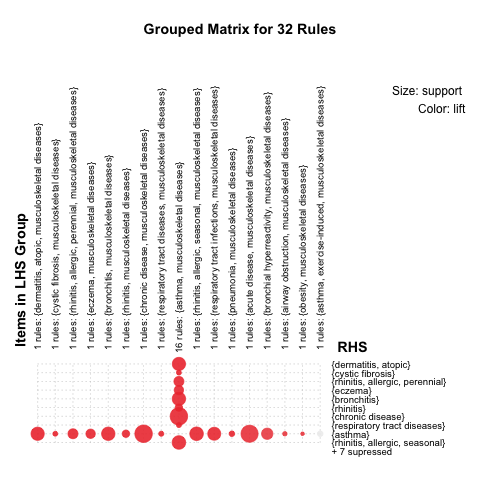

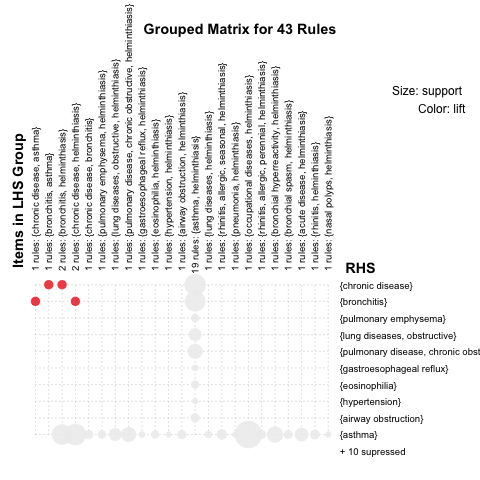

RCall.RObject{RCall.StrSxp}
character(0)


In [40]:
arules_viz(itemsets_ped)
arules_viz(itemsets_adult)

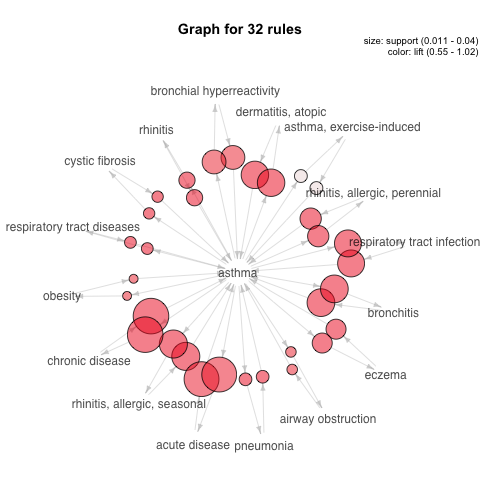

In [41]:
arules_viz(itemsets_ped, "graph");

  Mining stopped (maxlen reached). Only patterns up to a length of 3 returned!


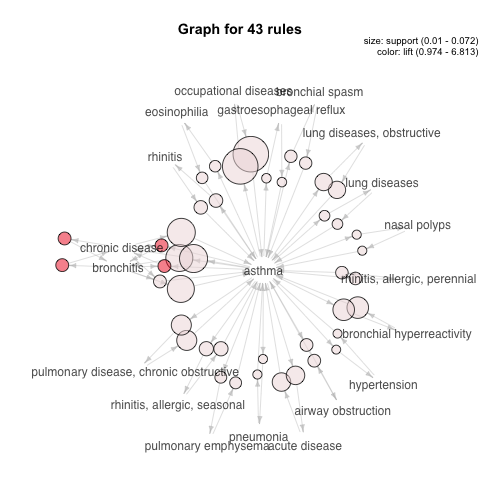

In [42]:
arules_viz(itemsets_adult, "graph");

In [43]:
mysql_disconnect(db_ped)
mysql_disconnect(db_adult)